In [1]:
from typing import List
import sys
sys.path.append('C:/Users/TomFi/Desktop/Cours/Projet IA/neuroforest-master')
sys.path.append('C:/Users/TomFi/Desktop/Cours/Projet IA/deepHL')
import numpy as np
import random as rd
import json
import os
import time
from tqdm import tqdm
from IPython import display
from PIL import Image, ImageDraw, ImageFont
from sklearn.preprocessing import MinMaxScaler


from main import to_vect, Coordinates, calculate_asrs, classify_asrs, dataloader, dataloader_2024
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchsummary


Loading data from : C:\Users\TomFi\Desktop\Cours\Projet IA\data_2022\trajectories_processed
Loading data from : C:\Users\TomFi\Desktop\Cours\Projet IA\data_2024\trajectories_processed


In [2]:
def create_batches(dataloader, session_type: str, batch_size: int, scale : int = 20,
                   subsample : bool = False, asrs_calc = classify_asrs, augmentation : bool = False, shuffle : bool = True):
    trajectories = []
    asrs = []
    print("Iterating through dataloader...")
    for sample in tqdm(dataloader):
        session = sample[session_type]
        if session is not None:
            if sample.answers is not None:
                player_coords = np.array([c["coord"].to_vect() for c in session.player_coords])
                player_coords = player_coords[:, [0, 2]]  # Keep only x and z coordinates
                asrs_score = asrs_calc(sample.answers)
                if augmentation:
                    # Add 8 different rotations of the trajectory
                    for i in range(0, 8):
                        # rotate from 45°
                        theta = np.radians(45*i)
                        c, s = np.cos(theta), np.sin(theta)
                        R = np.array([[c, -s], [s, c]])
                        rotated_coords = np.dot(player_coords, R)
                        trajectories.append(rotated_coords)
                        asrs_std = 3.1191546250994713
                        ICC = 0.75
                        intraclass_var = asrs_std**2 * (1/ICC - 1)
                        simulated_asrs = rd.gauss(asrs_score, intraclass_var)
                        asrs.append(simulated_asrs)

                else :
                    trajectories.append(player_coords)
                    asrs.append(asrs_score)

    # Pad / Truncate trajectories
    length = 30000
    padded_trajectories = []
    for traj in trajectories:
        if len(traj) < length:
            padded_traj = np.pad(traj, ((0, length - len(traj)), (0, 0)), mode='edge')
        else :
            padded_traj = traj
        truncated_traj = padded_traj[:length]
        padded_trajectories.append(truncated_traj)

    # Subsample trajectories
    if subsample:
        length = length // scale
        trajectories = np.array([np.array_split(player_coords, scale) for player_coords in padded_trajectories])
        trajectories = np.concatenate(trajectories, axis=0)
        trajectories = [coords - coords[0] for coords in trajectories]
        asrs = np.array([asrs_score for asrs_score in asrs for _ in range(scale)])
    else:
        trajectories = list(padded_trajectories)  

    # Shuffle trajectories
    tensor_trajectories = torch.tensor(trajectories, dtype=torch.float32)
    if shuffle :
        seed = 42
        permute = torch.randperm(len(tensor_trajectories), generator=torch.Generator().manual_seed(seed))
        tensor_trajectories = tensor_trajectories[permute]
        asrs = np.array(asrs)[permute]

    # Create batches
    num_batches = min(len(tensor_trajectories), len(asrs)) // batch_size
    if len(asrs) == len(trajectories):
        batches = tensor_trajectories[:num_batches * batch_size].view(num_batches, batch_size, length, 2)
        asrs = torch.tensor(np.array(asrs[:num_batches * batch_size])).view(num_batches, batch_size)
        # Reduce the sample rate
        batches = batches[:, :, ::25]    

    return batches, asrs

In [65]:
def data_setup(dataloader = dataloader, scale : int = 5, batch_size : int = 60, augmentation : bool = False):
    # Create batches for "uniform" and "patchy" session types
    uniform_batches,asrs = create_batches(dataloader, "uniform", batch_size, subsample=True, asrs_calc = calculate_asrs, scale=scale, augmentation=augmentation)
    patchy_batches,asrs_2 = create_batches(dataloader, "patchy", batch_size, subsample=True, asrs_calc = calculate_asrs, scale=scale, augmentation=augmentation)
    asrs = torch.cat((asrs, asrs_2), 0)
    batches = torch.cat((uniform_batches, patchy_batches), 0)
    high_probability_adhd = torch.Tensor((np.array(asrs) >= 24).astype(int))

    print(f"Trajectory batches shape: {batches.shape}")
    print(f"Target batches shape: {high_probability_adhd.shape}")

    return batches, asrs

# Test different scales

Creating batches...


  0%|          | 0/39 [00:00<?, ?it/s]

100%|██████████| 39/39 [00:22<00:00,  1.73it/s]


Creating batches...


100%|██████████| 39/39 [00:21<00:00,  1.78it/s]


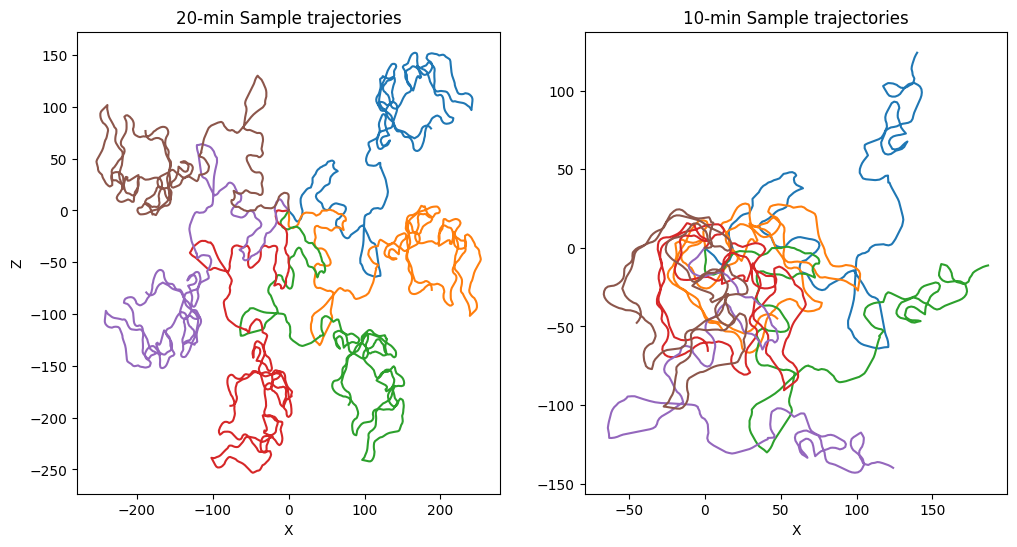

In [21]:
batch_size = 6
scales = [1,2]
x_1, _ = create_batches(dataloader, "uniform", batch_size, scale=scales[0], subsample=True, augmentation=True, shuffle=False)
x_2, _ = create_batches(dataloader, "uniform", batch_size, scale=scales[1], subsample=True, augmentation=True, shuffle=False)
duration_1, duration_2 = x_1.shape[2]//60, x_2.shape[2]//60

# Plot the first 10 trajectories
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
for i in range(batch_size):
    axes[0].plot(x_1[0, i, :, 0].flatten(), x_1[0, i, :, 1].flatten(), label=f'{duration_1}-min trajectories {i+1}')
    axes[1].plot(x_2[0, i, :, 0].flatten(), x_2[0, i, :, 1].flatten(), label=f'{duration_2}-min trajectories {i+1}')
axes[0].set_xlabel('X')
axes[0].set_ylabel('Z')
axes[0].set_title(f'{duration_1}-min Sample trajectories')
axes[1].set_xlabel('X')
axes[1].set_title(f'{duration_2}-min Sample trajectories')
plt.show()

# Model definition

In [4]:
class LSTMWithAttention(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, dropout, seq_len):
        super(LSTMWithAttention, self).__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True, dropout=dropout)
        self.attention = nn.MultiheadAttention(embed_dim=hidden_dim, num_heads=1, dropout=dropout)
        self.dense1 = nn.Linear(hidden_dim, 1)
        self.dense2 = nn.Linear(seq_len,1)
        self.activation = nn.Sigmoid()
        self.seq_len = seq_len

    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        lstm_out = lstm_out.permute(1, 0, 2)
        attention_out = self.attention(lstm_out, lstm_out, lstm_out)[0]
        dense_out = self.dense1(attention_out).view(-1, self.seq_len)
        dense_out = self.dense2(dense_out)
        probability = self.activation(dense_out)
        return probability

# Define the model parameters
input_dim = 2  # x and z coordinates
hidden_dim = 64
num_layers = 4
dropout = 0.5

In [96]:
class TemporalCNN(nn.Module):
    def __init__(self, seq_len, n_channels=2, 
                 first_conv_params : dict = {"kernel_size": 20, "stride": 1, "padding": 1},
                 second_conv_params : dict = {"kernel_size": 5, "stride": 1, "padding": 1}):
        super(TemporalCNN, self).__init__()
        kernel_size = first_conv_params["kernel_size"]
        stride = first_conv_params["stride"]
        padding = first_conv_params["padding"]
        self.conv1 = nn.Conv1d(n_channels, 32, kernel_size=kernel_size, stride=stride, padding=padding)
        # Compute new sequence length after first convolution
        self.seq_len = (seq_len - kernel_size + 2 * padding) // stride + 1
        self.bn1 = nn.BatchNorm1d(32)
        kernel_size = second_conv_params["kernel_size"]
        stride = second_conv_params["stride"]
        padding = second_conv_params["padding"]
        self.conv2 = nn.Conv1d(32, 64, kernel_size=kernel_size, stride=stride, padding=padding)
        # Compute new sequence length after 2nd convolution
        self.seq_len = (self.seq_len - kernel_size + 2 * padding) // stride + 1        
        self.bn2 = nn.BatchNorm1d(64)
        self.dropout = nn.Dropout(p=0.5)
        self.fc1 = nn.Linear(64, 1)
        self.fc2 = nn.Linear(self.seq_len, 1)
        self.init_weights()

    def init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv1d) or isinstance(m, nn.Linear):
                nn.init.kaiming_normal_(m.weight)
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)

                    
    def forward(self, x):
        x = x.permute(0, 2, 1)  # Change shape to (batch_size, n_channels, seq_len)
        x = self.conv1(x)
        x = self.bn1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.dropout(x)
        x = F.relu(x)
        x = x.permute(0, 2, 1)  # Change shape back to (batch_size, seq_len, n_channels)
        x = self.fc1(x)
        x = F.relu(x)
        x = x.permute(0, 2, 1)  # Change shape to (batch_size, 1, seq_len)
        x = self.fc2(x).flatten()
        # x = F.sigmoid(x)
        return x.squeeze()

# Training

In [208]:
x_train, y_train = data_setup(dataloader=dataloader,scale=1, batch_size=6, augmentation=True)
x_test, y_test = data_setup(dataloader=dataloader_2024,scale=1, batch_size=9, augmentation=False)
seq_len = x_train.shape[2]

Iterating through dataloader...


100%|██████████| 39/39 [00:14<00:00,  2.73it/s]


Iterating through dataloader...


100%|██████████| 39/39 [00:13<00:00,  2.82it/s]


Trajectory batches shape: torch.Size([102, 6, 1200, 2])
Target batches shape: torch.Size([102, 6])
Iterating through dataloader...


100%|██████████| 19/19 [00:06<00:00,  2.83it/s]


Iterating through dataloader...


100%|██████████| 19/19 [00:06<00:00,  2.88it/s]


Trajectory batches shape: torch.Size([2, 9, 1200, 2])
Target batches shape: torch.Size([2, 9])


In [209]:
scaler = MinMaxScaler()
all_asrs = torch.cat((y_train.flatten(), y_test.flatten()), 0)
all_asrs_norm = scaler.fit_transform(all_asrs.reshape(-1,1)).astype(np.float32)
y_train = all_asrs_norm[:y_train.shape[0]*y_train.shape[1]].reshape(y_train.shape)
y_test = all_asrs_norm[y_train.shape[0]*y_train.shape[1]:].reshape(y_test.shape)

In [210]:
model = LSTMWithAttention(input_dim, hidden_dim, num_layers, dropout, seq_len)

In [211]:
# Define the custom MSE loss function
class CustomMSELoss(nn.Module):
    def __init__(self, lambda_var):
        super(CustomMSELoss, self).__init__()
        self.mse_loss = nn.MSELoss()
        self.lambda_var = lambda_var

    def forward(self, outputs, targets):
        mse_loss = self.mse_loss(outputs, targets)
        # entropy = -outputs * torch.log(outputs) - (1 - outputs) * torch.log(1 - outputs)
        variance_pen = torch.exp(-self.lambda_var * torch.var(outputs))
        return mse_loss + variance_pen

In [212]:
def train(model, x_train, y_train, x_test, y_test, num_epochs : int = 100, learning_rate : float = 0.001,
          monitor_gradients : bool = False, lambda_var : float = 0.1):
    # Define the loss function and optimizer
    criterion = CustomMSELoss(lambda_var=lambda_var)
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    # Initialize plot
    plt.ion()
    fig, ax = plt.subplots(figsize=(12, 6))
    losses = []
    val_losses = []

    # Example training loop
    for epoch in range(num_epochs):
        train_loss = 0
        for batch in range(x_train.shape[0]):
            x_train_batch = x_train[batch]
            y_train_batch = y_train[batch]
            
            model.train()
            optimizer.zero_grad()
            
            # Forward pass
            outputs = model(x_train_batch)
            loss = criterion(outputs.squeeze(), torch.tensor(y_train_batch, dtype=torch.float32))
            
            # Backward pass and optimization
            loss.backward()
            optimizer.step()
            train_loss += loss.item()/x_train.shape[0]
            

            # Monitor gradients
            if monitor_gradients : 
                for name, param in model.named_parameters():
                    if param.grad is not None:
                        print(f'{name}: {param.grad.abs().mean()}')

        # add validation on test set
        outputs = []
        for batch in range(x_test.shape[0]):
            x_test_batch = x_test[batch]
            y_test_batch = y_test[batch]            
            outputs.append(model(x_test_batch).squeeze().detach().numpy())
        val_loss = criterion(torch.tensor(outputs).squeeze(), torch.tensor(y_test).squeeze()).item()


        print(f'Epoch {epoch+1}/{num_epochs}, batch {batch+1}/{x_train.shape[0]}, Loss: {train_loss}, Val Loss: {val_loss}')
        
        # Dynamic plot to showcase the evolution of the loss
        losses.append(train_loss)
        val_losses.append(val_loss)
        ax.clear()
        ax.plot(losses, label='Train Loss', c = 'navy')
        ax.plot(val_losses, label='Validation Loss', c= 'r')
        ax.set_xlabel('Epoch')
        ax.set_ylabel('Loss')
        ax.set_title('Training and Validation Loss')
        ax.legend()
        display.clear_output(wait=True)
        display.display(fig) 

    plt.ioff()
    plt.close()

In [221]:
temporal_cnn = TemporalCNN(seq_len, 
                           first_conv_params={"kernel_size": 10, "stride": 5, "padding": 0},
                           second_conv_params={"kernel_size": 5, "stride": 5, "padding": 0})
torchsummary.summary(temporal_cnn, (seq_len, 2))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv1d-1              [-1, 32, 239]             672
       BatchNorm1d-2              [-1, 32, 239]              64
            Conv1d-3               [-1, 64, 47]          10,304
       BatchNorm1d-4               [-1, 64, 47]             128
           Dropout-5               [-1, 64, 47]               0
            Linear-6                [-1, 47, 1]              65
            Linear-7                 [-1, 1, 1]              48
Total params: 11,281
Trainable params: 11,281
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.19
Params size (MB): 0.04
Estimated Total Size (MB): 0.24
----------------------------------------------------------------


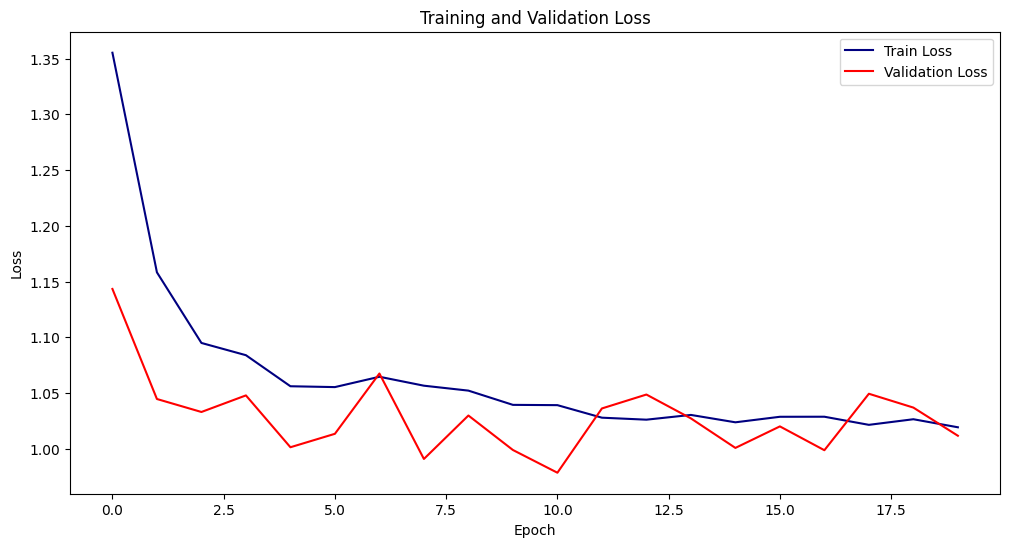

In [222]:
train(temporal_cnn, x_train, y_train, x_test, y_test, num_epochs=20, learning_rate=0.0005, lambda_var=1)

# Evaluating models

In [223]:
def eval_binaryclass(model, x_test, y_test):
    outputs = []
    for batch in range(x_test.shape[0]):
        x_test_batch = x_test[batch]
        outputs.append(model(x_test_batch).squeeze().detach().numpy())
    outputs = np.array(outputs).flatten()
    test_HP_adhd = np.array(y_test).flatten()
    threshold = np.arange(0.02, 0.98, 0.02)
    accuracy, precision, recall = [], [], []
    for t in threshold:
        tp = np.sum((outputs > t) & (test_HP_adhd == 1)) + 1e-10
        tn = np.sum((outputs <= t) & (test_HP_adhd == 0))+ 1e-10
        fp = np.sum((outputs > t) & (test_HP_adhd == 0))+ 1e-10
        fn = np.sum((outputs <= t) & (test_HP_adhd == 1))+ 1e-10
        # print(f"TP : {tp}, TN : {tn}, FP : {fp}, FN : {fn}")
        precision.append(tp / (tp + fp))
        recall.append(tp / (tp + fn))
    f1 = 2 * np.array(precision) * np.array(recall) / (np.array(precision) + np.array(recall))
    plt.plot(threshold, precision, label = 'Precision')
    plt.plot(threshold, recall, label = 'Recall')
    plt.plot(threshold, f1, label = 'F1')
    plt.xlabel('Threshold')
    plt.ylabel('Accuracy')
    plt.title('Result metrics vs Threshold')
    plt.legend()
    plt.show()

    return f1, outputs


def eval_score(model, x_test, y_test):
    outputs = []
    for batch in range(x_test.shape[0]):
        x_test_batch = x_test[batch]
        outputs.append(model(x_test_batch).squeeze().detach().numpy())
    outputs = np.array(outputs).flatten()
    test_HP_adhd = np.array(y_test).flatten()
    mse = np.mean((outputs - test_HP_adhd) ** 2)
    print(f'Mean Squared Error: {mse}')
    # plot the results
    plt.plot(outputs, label='Predictions', c = 'g')
    plt.plot(test_HP_adhd, label='True values', c = 'orange')
    plt.legend()
    plt.show()
    return mse, outputs

Mean Squared Error: 0.12995147705078125


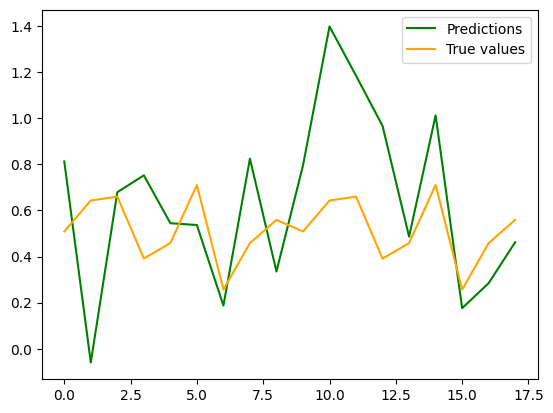

In [224]:
mse, ouputs = eval_score(temporal_cnn, x_test, y_test)

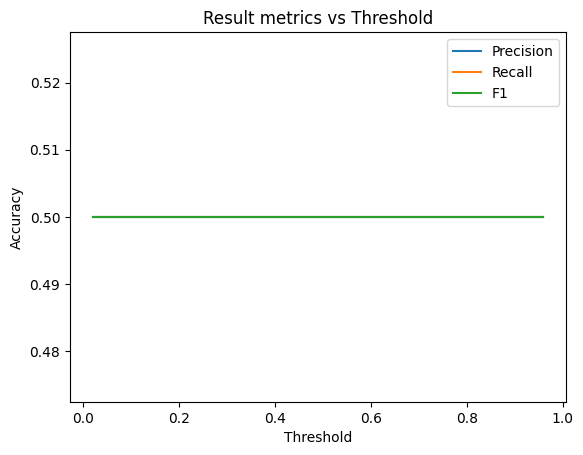

In [ ]:
f1 = eval_binaryclass(temporal_cnn, x_test, y_test)

In [94]:
id_threshold = np.argmax(f1)
max_f1 = f1[id_threshold]
print(f"Best threshold : {id_threshold * 0.02 + 0.02}, achieving F1 score of {max_f1}")

Best threshold : 0.02, achieving F1 score of 0.5


<>:14: SyntaxWarning: invalid escape sequence '\m'
<>:14: SyntaxWarning: invalid escape sequence '\s'
<>:14: SyntaxWarning: invalid escape sequence '\m'
<>:14: SyntaxWarning: invalid escape sequence '\s'
C:\Users\TomFi\AppData\Local\Temp\ipykernel_13532\4226674619.py:14: SyntaxWarning: invalid escape sequence '\m'
  plt.plot(x, p, 'k', linewidth=2, label=f'Fit: $\mu={mu}$, $\sigma={std}$')
C:\Users\TomFi\AppData\Local\Temp\ipykernel_13532\4226674619.py:14: SyntaxWarning: invalid escape sequence '\s'
  plt.plot(x, p, 'k', linewidth=2, label=f'Fit: $\mu={mu}$, $\sigma={std}$')


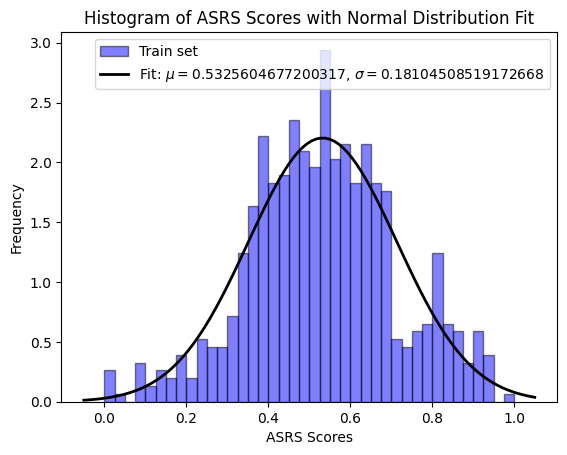

In [220]:
from scipy.stats import norm

# Fit a normal distribution to the data
mu, std = norm.fit(y_train.flatten())

# Plot the histogram
plt.hist(y_train.flatten(), bins=40, alpha=0.5, label='Train set', color='blue', edgecolor='black', density=True)
# plt.hist(y_test.flatten(), bins=40, alpha=0.5, label='Test set', color='red', edgecolor='black', density=True)

# Plot the PDF
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu, std)
plt.plot(x, p, 'k', linewidth=2, label=f'Fit: $\mu={mu}$, $\sigma={std}$')

# Add labels and title
plt.xlabel('ASRS Scores')
plt.ylabel('Frequency')
plt.title('Histogram of ASRS Scores with Normal Distribution Fit')
plt.legend()
plt.show()